In [1]:
#!pip install xarray pandas matplotlib scipy netCDF4 ipympl numba

In [3]:
#%matplotlib ipympl

import matplotlib.pyplot as pl
import xarray as xr
import numpy as np
from numba import njit

import sys
sys.path.append('/home/bart/meteo/projects_git/python')

#from statistics import power_spectrum
from spectral_tools import power_spectrum_2d

In [4]:
"""
Global settings.
"""
path = '/home/scratch2/bart/slocs_rf/sims_ideal/drycblles_v1/'

dx = np.array([1600, 800, 400, 200, 100, 50])
itot_range = np.array([48, 96, 192, 384, 768, 1536])
u_range = [0,5,10]
mlen_range = ['iso', 'aniso']

Text(0, 0.5, '$\\lambda$ (m)')

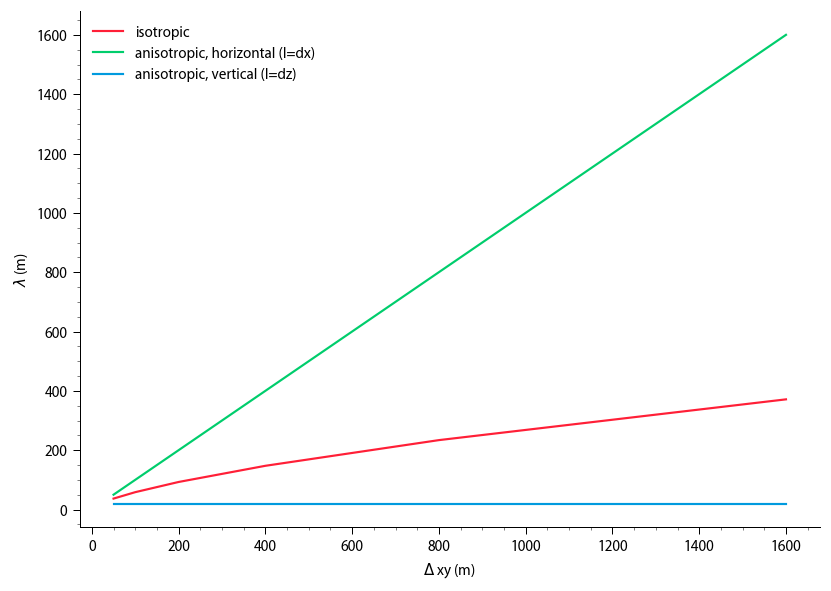

In [5]:
"""
Length scales.
"""
dz = 20.
l1 = (dx*dx*dz)**(1/3)
l2h = dx
l2v = np.ones_like(dx)*dz

pl.figure(layout='tight')
pl.plot(dx, l1, label='isotropic')
pl.plot(dx, l2h, label='anisotropic, horizontal (l=dx)')
pl.plot(dx, l2v, label='anisotropic, vertical (l=dz)')
pl.legend()
pl.xlabel(r'$\Delta$ xy (m)')
pl.ylabel(r'$\lambda$ (m)')

In [6]:
"""
Open cross-section NetCDFs.
"""

dss = {}

u = 5
for var in ['u', 'w', 'th']:
    for itot in itot_range:
        for mlen in mlen_range:
            dir = f'{itot}x{itot}_{u}_{mlen}'
            case = f'{dir}_{var}'
            dss[case] = xr.open_dataset(f'{path}/{dir}/{var}.xy.nc', decode_times=False)

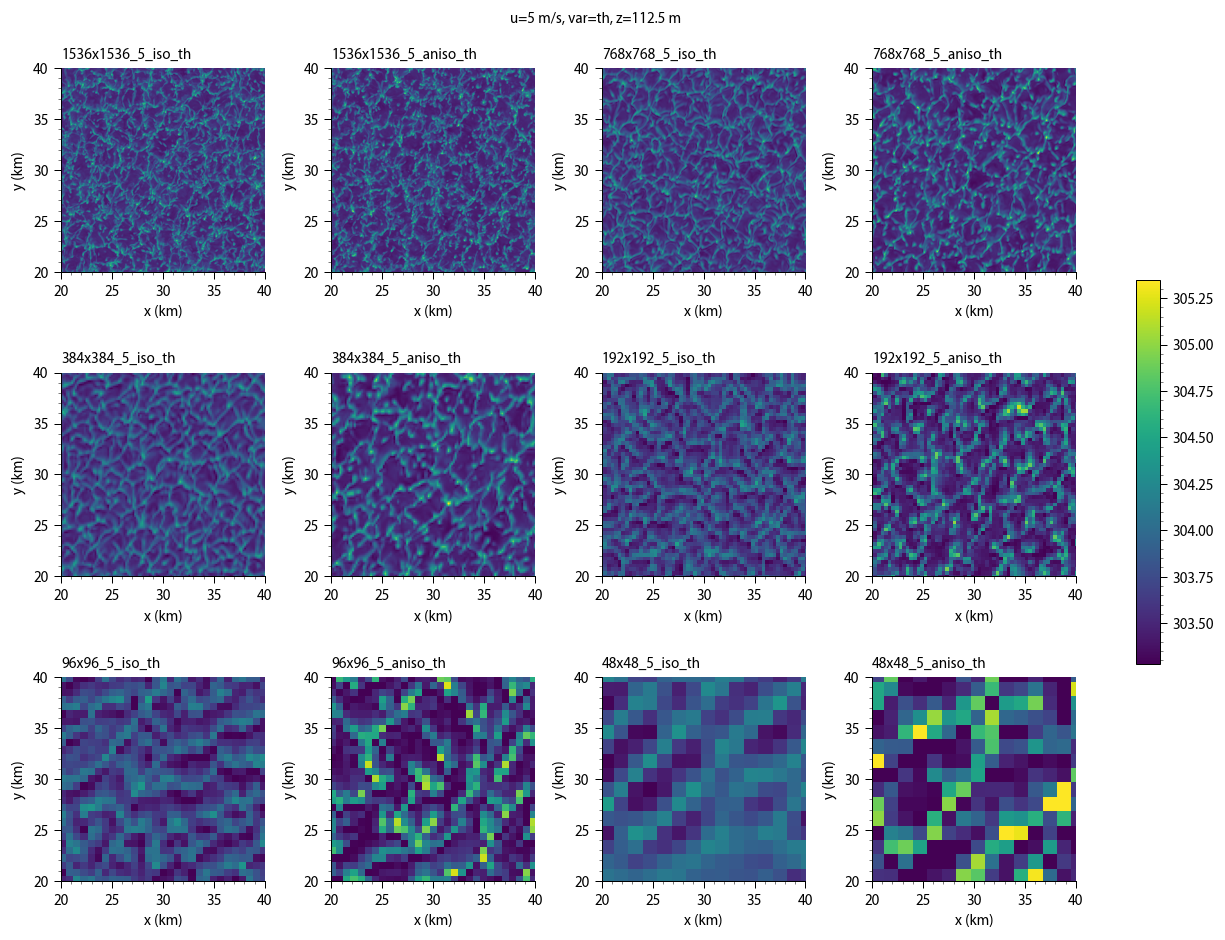

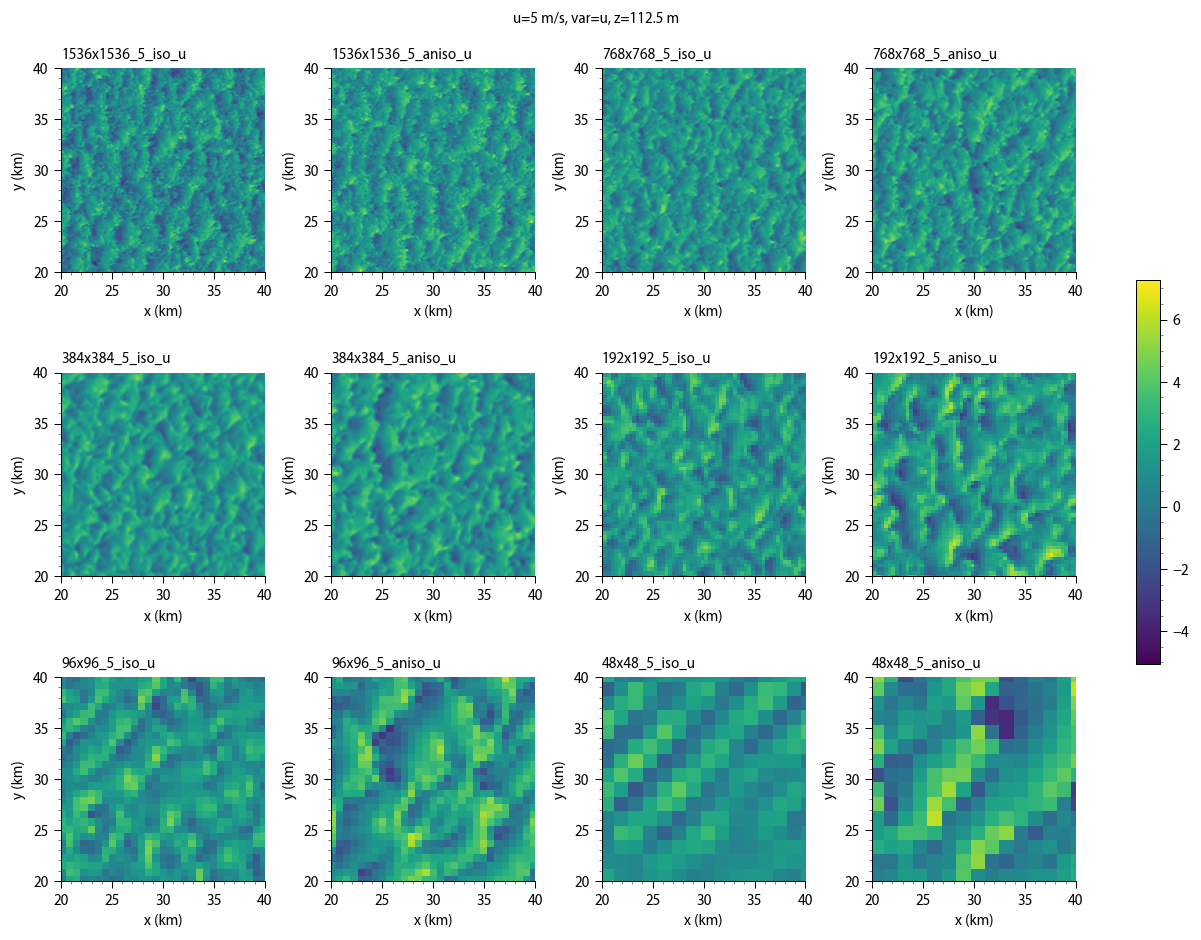

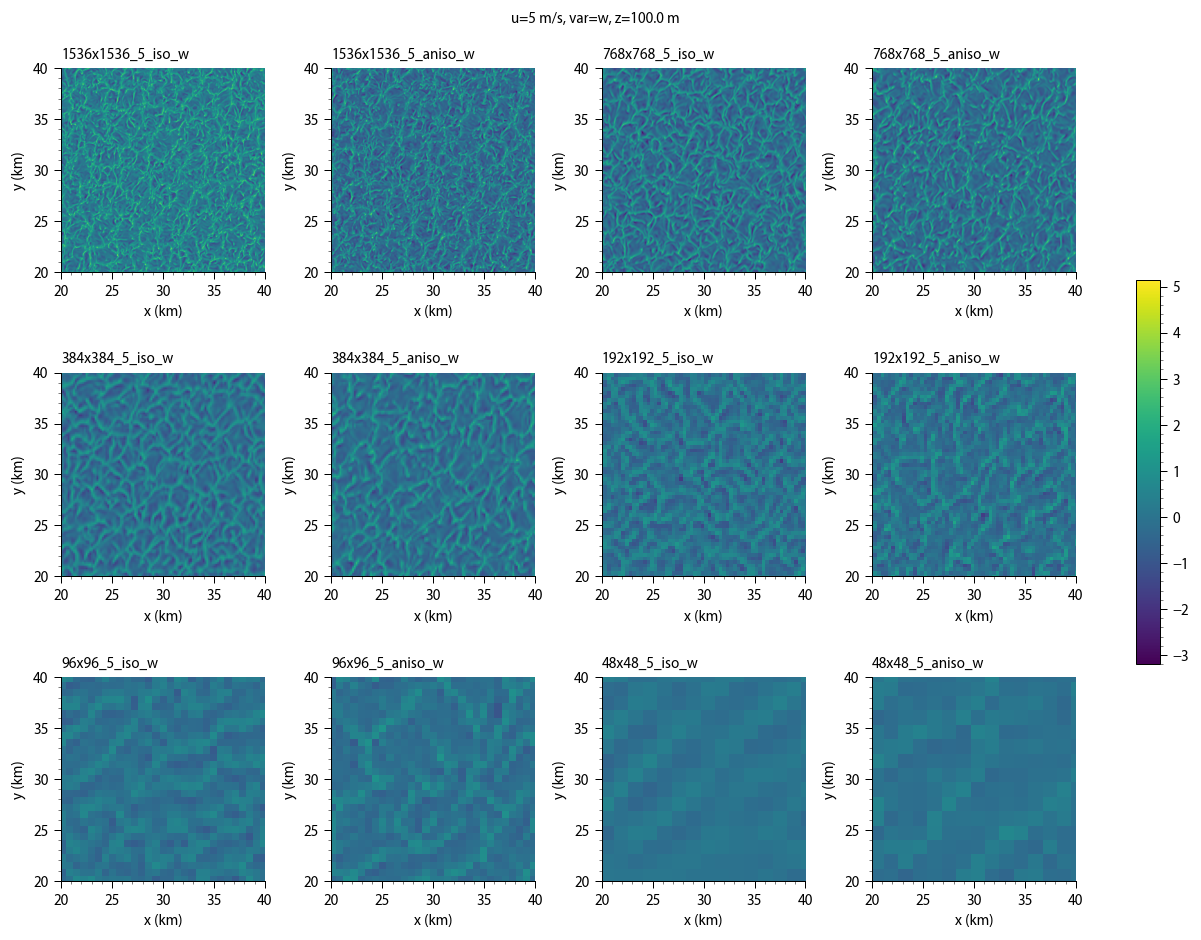

In [8]:
"""
Plot cross-sections.
"""
pl.close('all')

def plot_cross(u, var, t, k, xy_lim=None):

    ds = dss[f'{48}x{48}_{u}_iso_{var}']
    z = ds.zh.values if var == 'w' else  ds.z.values

    fig=pl.figure(figsize=(10,8))
    pl.suptitle(f'u={u} m/s, var={var}, z={z[k]} m')

    ax = None
    for i,itot in enumerate(itot_range[::-1]):
        for j,mlen in enumerate(('iso', 'aniso')):
            sp = (i*2)+j+1

            #if ax is None:
            ax = pl.subplot(3,4,sp, aspect='equal')
            #else:
            #    pl.subplot(3,4,sp, aspect='equal', sharex=ax, sharey=ax)

            case = f'{itot}x{itot}_{u}_{mlen}_{var}'
            pl.title(case, loc='left')

            ds = dss[case]
            data = ds[var][t,k,:,:].values

            if i==0:
                vmin = data.min()
                vmax = data.max()

            im=pl.imshow(data, extent=[0, 67.8, 0, 67.8], vmin=vmin, vmax=vmax)
        
            pl.xlabel('x (km)')
            pl.ylabel('y (km)')

            if xy_lim is not None:
                pl.xlim(xy_lim)
                pl.ylim(xy_lim)

            del data

    pl.tight_layout()

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
    fig.colorbar(im, cax=cbar_ax)

    pl.savefig(f'figs/drycbl_cross_{var}_{k}.png')

k = 1
xy_lim = (20, 40)

plot_cross(u=5, var='th', t=-1, k=k, xy_lim=xy_lim)
plot_cross(u=5, var='u',  t=-1, k=k, xy_lim=xy_lim)
plot_cross(u=5, var='w',  t=-1, k=k, xy_lim=xy_lim)

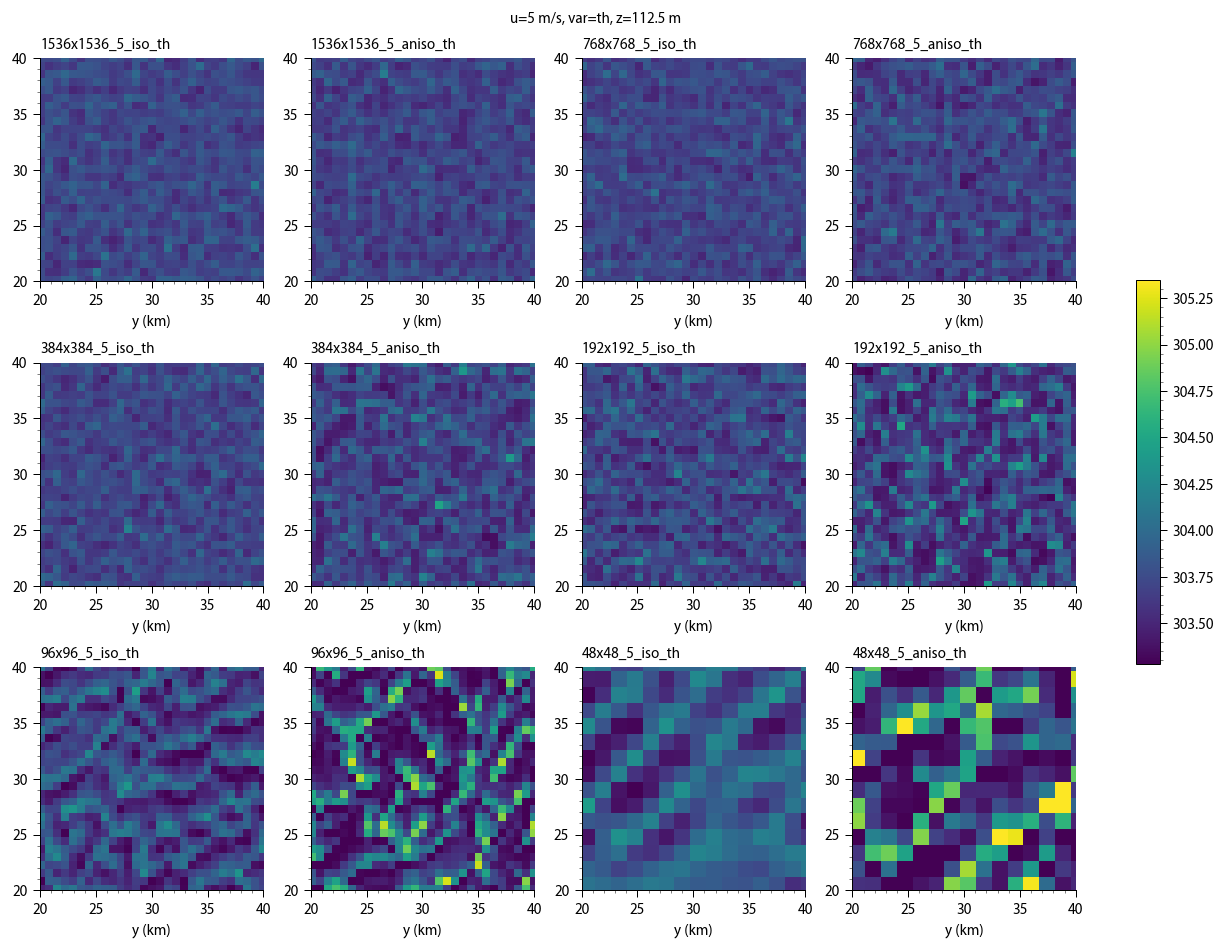

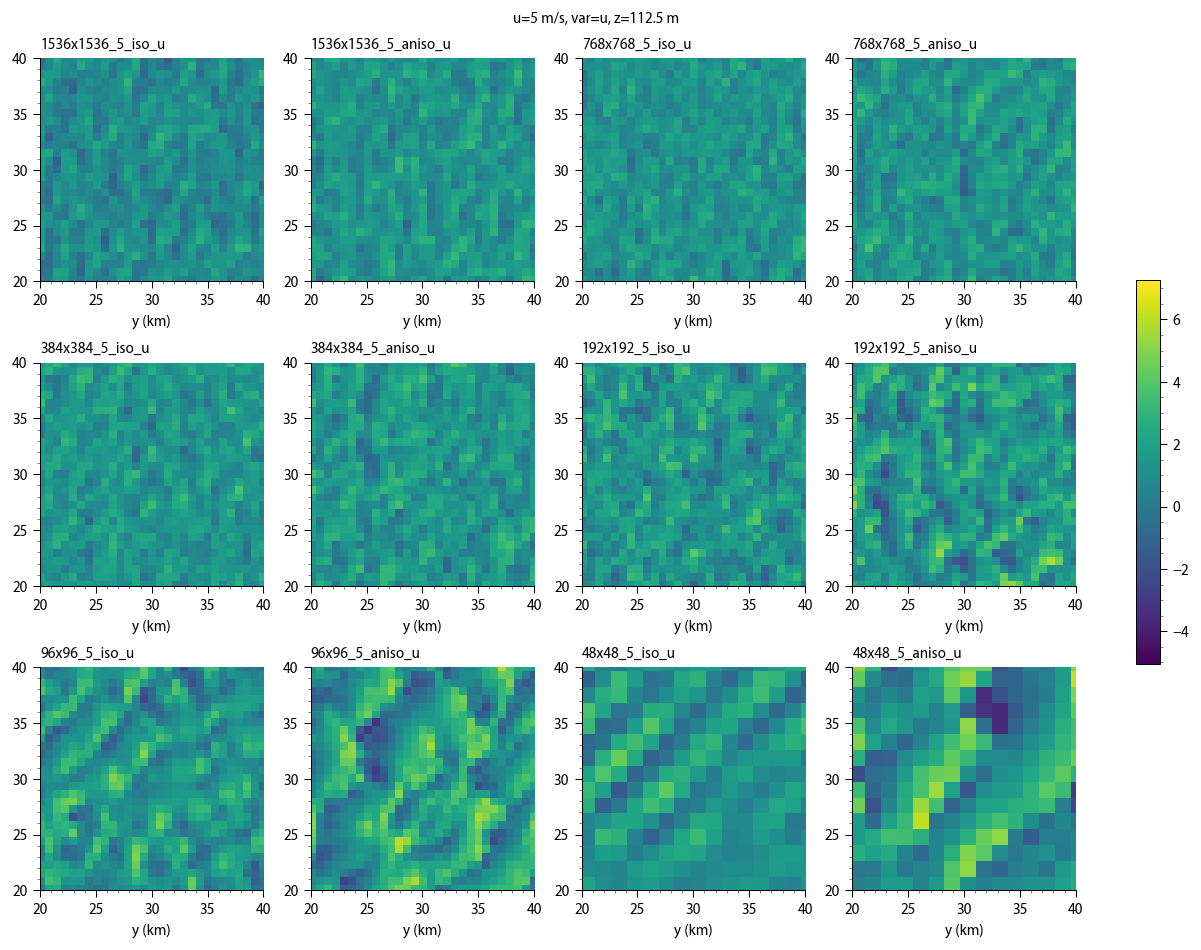

In [9]:
"""
Plot cross-sections: coarse grained.
"""
pl.close('all')

@njit
def coarse_grain(fld_out, fld_in, ijtot_out, n_av):
    for j in range(ijtot_out):
        for i in range(ijtot_out):
            i0 = (i+0)*n_av
            i1 = (i+1)*n_av
            j0 = (j+0)*n_av
            j1 = (j+1)*n_av

            fld_out[j,i] = fld_in[j0:j1,i0:i1].mean()


def plot_cross(u, var, t, k, xy_lim=None):

    ds = dss[f'{48}x{48}_{u}_iso_{var}']
    z = ds.zh.values if var == 'w' else  ds.z.values

    fig=pl.figure(figsize=(10,8))
    pl.suptitle(f'u={u} m/s, var={var}, z={z[k]} m')

    ijtot_out = 96

    ax = None
    for i,itot in enumerate(itot_range[::-1]):

        n_av = int(itot/ijtot_out)
        fld = np.zeros((ijtot_out, ijtot_out))

        for j,mlen in enumerate(('iso', 'aniso')):
            sp = (i*2)+j+1

            if ax is None:
                ax = pl.subplot(3,4,sp, aspect='equal')
            else:
                pl.subplot(3,4,sp, aspect='equal', sharex=ax, sharey=ax)

            case = f'{itot}x{itot}_{u}_{mlen}_{var}'
            pl.title(case, loc='left')

            ds = dss[case]
            data = ds[var][t,k,:,:].values

            # Only coarse-grain if resolution is higher than output.
            if itot > ijtot_out:
                coarse_grain(fld, data, ijtot_out, n_av)
            else:
                fld = data

            if i==0:
                vmin = data.min()
                vmax = data.max()

            im=pl.imshow(fld, extent=[0, 67.8, 0, 67.8], vmin=vmin, vmax=vmax)
        
            pl.xlabel('x (km)')
            pl.xlabel('y (km)')

            if xy_lim is not None:
                pl.xlim(xy_lim)
                pl.ylim(xy_lim)

            del data

    pl.tight_layout()

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
    fig.colorbar(im, cax=cbar_ax)

k = 1
xy_lim = (20, 40)

plot_cross(u=5, var='th', t=-1, k=k, xy_lim=xy_lim)
plot_cross(u=5, var='u',  t=-1, k=k, xy_lim=xy_lim)

In [10]:
"""
Check: total resolved variance in all runs.
"""
variance = {}

u = 5
for var in ['u', 'w', 'th']:
    for itot in itot_range:
        for mlen in mlen_range:
            case = f'{itot}x{itot}_{u}_{mlen}_{var}'

            for k in range(4):
                data = dss[case][var][:,k,:,:].values
                name = f'{case}_{k}'
                variance[name] = np.var(data, axis=(1,2))
                del data

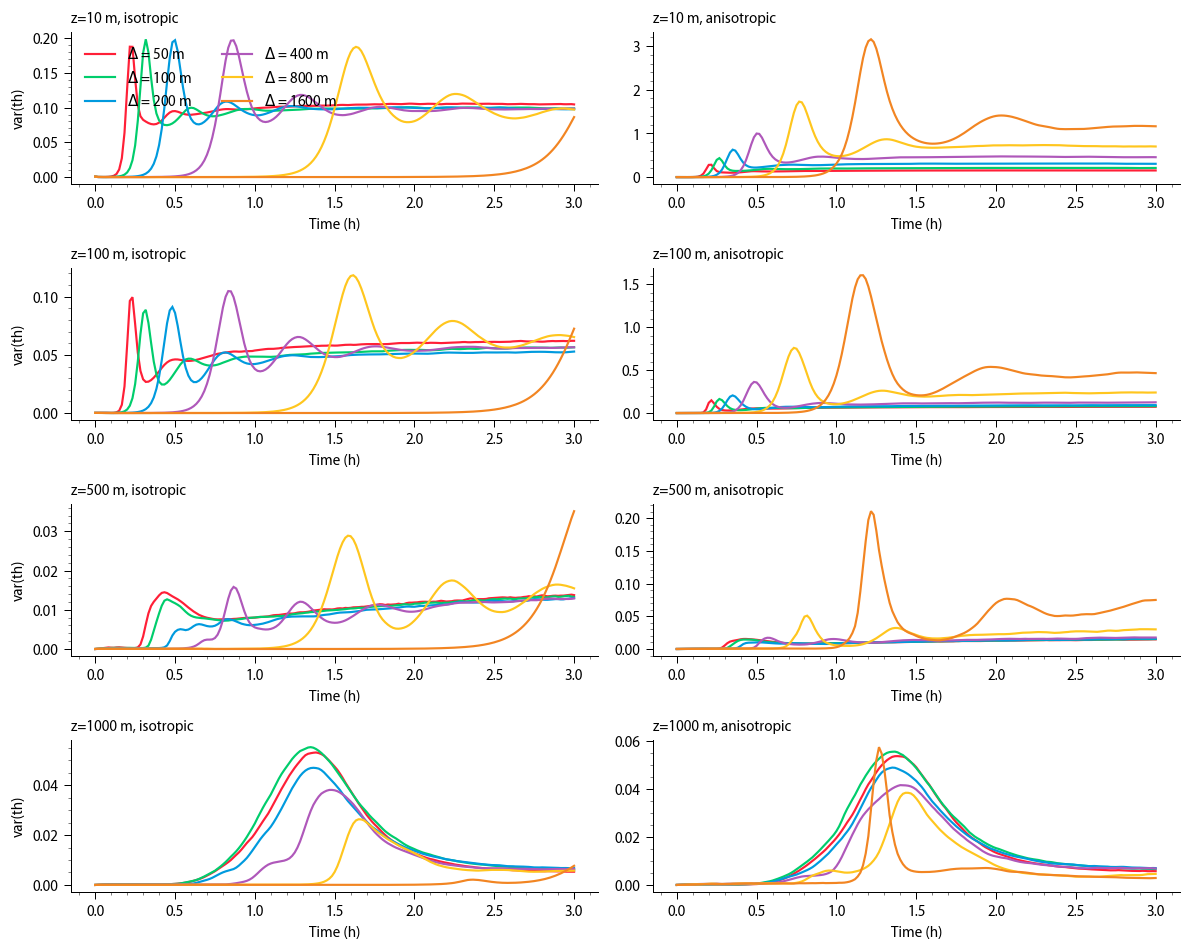

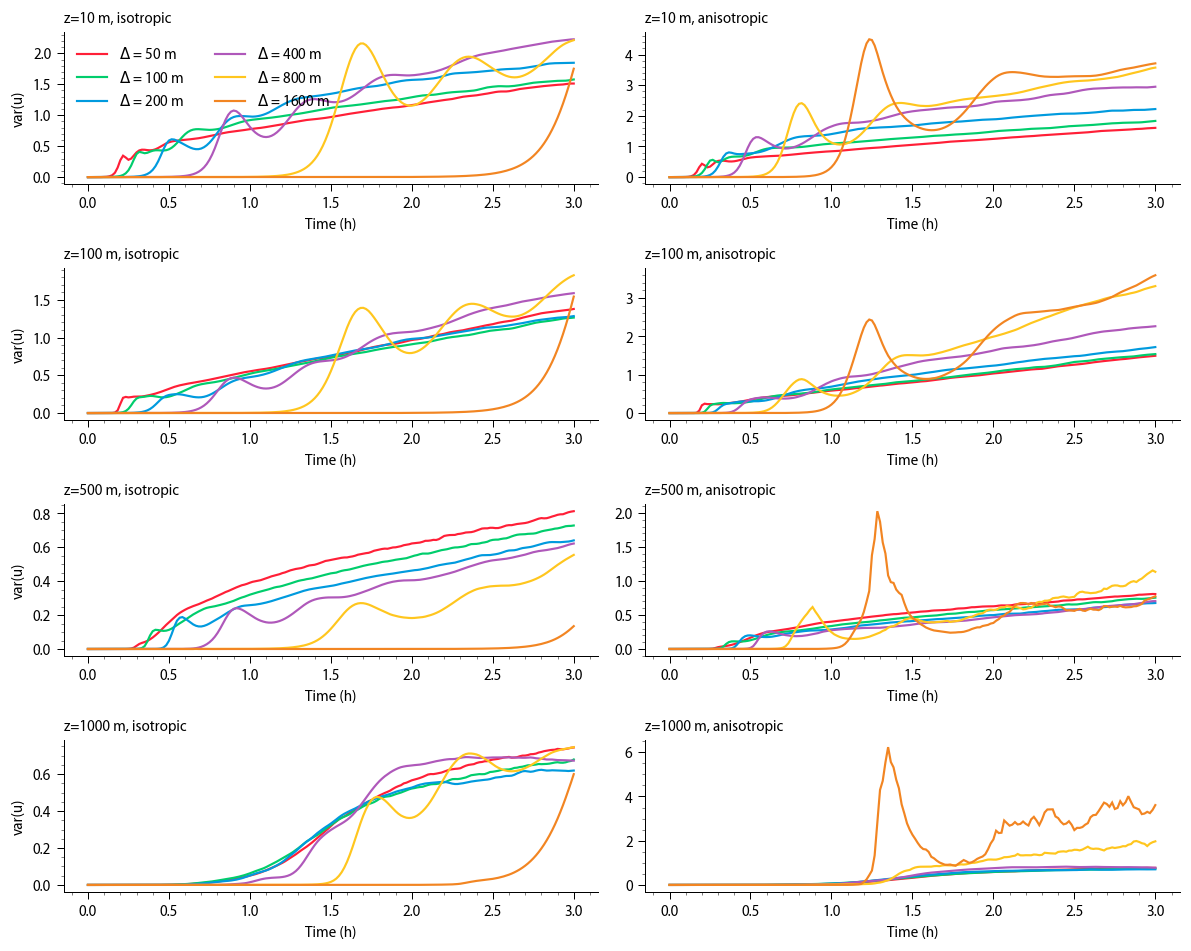

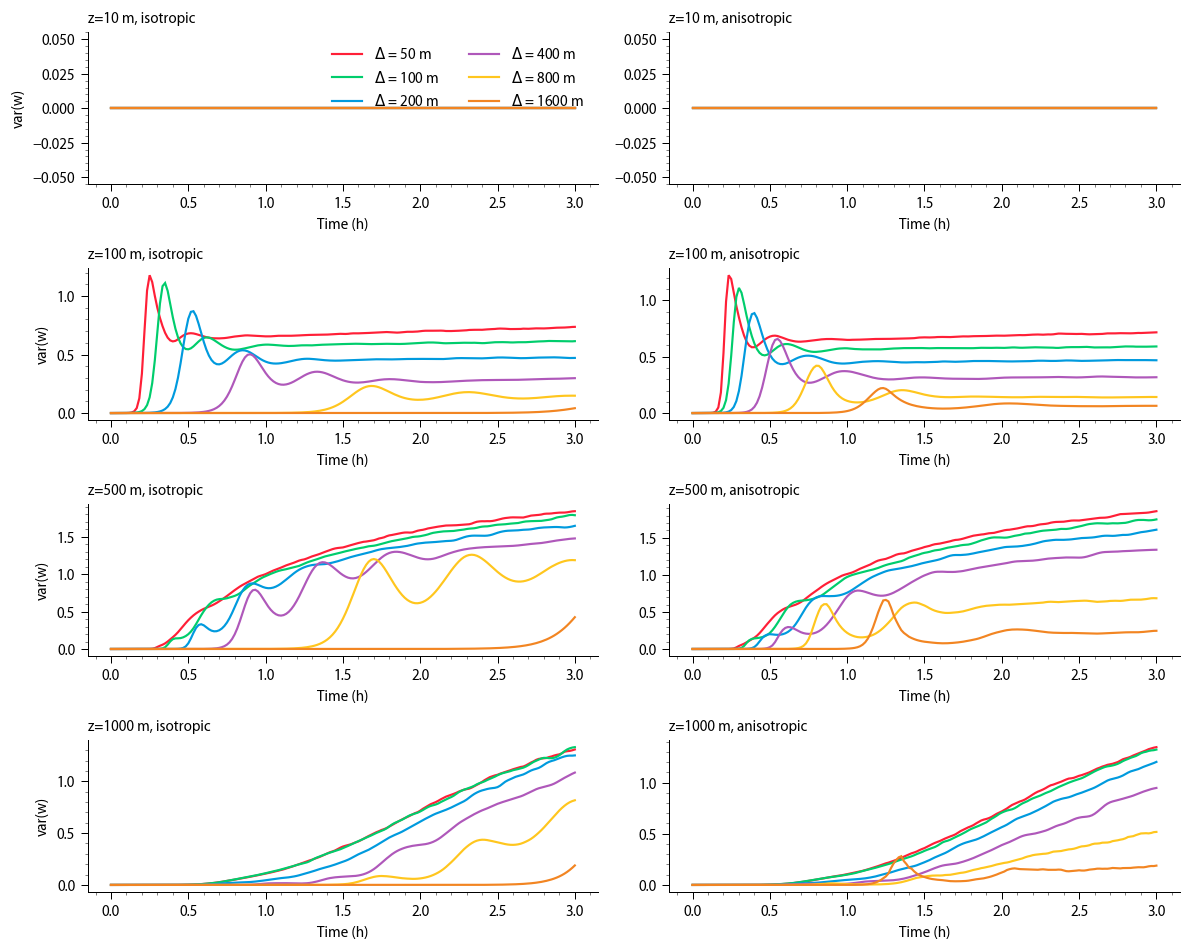

In [11]:
"""
Plot total variance as function of time.
"""
pl.close('all')

def plot_var(u, var):

    time = np.arange(0, 10801, 60) / 3600.
    z = np.array([10,100,500,1000])

    pl.figure(figsize=(10,8), layout='tight')

    for k in range(4):
        pl.subplot(4,2,(2*k)+1)
        pl.title(rf'z={z[k]} m, isotropic', loc='left')

        for itot in itot_range[::-1]:
            case = f'{itot}x{itot}_{u}_iso_{var}_{k}'
            pl.plot(time, variance[case], label=rf'$\Delta$ = {76800/itot:.0f} m')
        
        pl.ylabel(rf'var({var})')
        pl.xlabel('Time (h)')

        if k==0:
            pl.legend(ncol=2)

    for k in range(4):
        pl.subplot(4,2,(2*k)+2)
        pl.title(rf'z={z[k]} m, anisotropic', loc='left')

        for itot in itot_range[::-1]:
            case = f'{itot}x{itot}_{u}_aniso_{var}_{k}'
            pl.plot(time, variance[case])

        pl.xlabel('Time (h)')
    
    pl.savefig(f'figs/drycbl_var_{var}.png')

plot_var(5, 'th')
plot_var(5, 'u')
plot_var(5, 'w')

In [14]:
"""
Create spatial spectra.
"""
class Spectra_xy:
    def __init__(self, path, case, var, k, t0=7200, t1=10800, mode='xy', clip=False):

        self.ds = xr.open_dataset(f'{path}/{case}/{var}.xy.nc', decode_times=False)
        self.ds = self.ds.sel(time=slice(t0, t1))

        self.x = self.ds['xh'].values if var == 'u' else self.ds['x'].values
        self.y = self.ds['yh'].values if var == 'v' else self.ds['y'].values

        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]

        self.xsize = self.x[-1] + self.dx if var == 'u' else self.x[-1] + self.dx/2
        self.ysize = self.y[-1] + self.dy if var == 'v' else self.y[-1] + self.dy/2

        if self.xsize != self.ysize:
            raise Exception('Oii, non-square domain not supported.')

        data = self.ds[var].values

        # Get radial wave numbers. These are in units [waves / domain].
        self.k_dom, _ = power_spectrum_2d(data[0,0,:,:], mode=mode, return_k=True)

        # Translate `k` to wavelength in [m].
        self.w_phy = np.zeros_like(self.k_dom, dtype=np.float32)
        self.w_phy[1:] = self.xsize / self.k_dom[1:]

        # Translate to wave number in [m-1].
        self.k_phy = np.zeros_like(self.w_phy)
        self.k_phy[1:] = 1/self.w_phy[1:]

        # Output spectra, averaged in time, but not height.
        self.E = np.zeros(self.k_phy.size, dtype=np.float32)

        # Create self.spectra.
        for t in range(self.ds.sizes['time']):
            spec = power_spectrum_2d(data[t,k,:,:], mode=mode, return_k=False)
            #var = np.var(data[t,k,:,:])
            #print(var, spec[1:].sum(), var-spec[1:].sum()) # Check: ~same.
            self.E[:] += spec

        self.E[:] /= self.ds.sizes['time']

        # Spectral energy is per wave number bin. Divide out, to get spectral density.
        dk = self.k_phy[1] - self.k_phy[0]
        self.PSD = self.E / dk

        if clip:
            # Remove radial wavenumbers that don't fit in x or y direction.
            kmax = int(self.x.size / 2 + 1)
            self.E = self.E[:,:kmax]
            self.PSD = self.PSD[:,:kmax]
            self.k_dom = self.k_dom[:kmax]
            self.w_phy = self.w_phy[:kmax]
            self.k_phy = self.k_phy[:kmax]
        
        del data

s_th = {}
s_u = {}
#s_w = {}

u = 5
for k in range(4):
    for itot in itot_range:
        for mlen in mlen_range:
            dir = f'{itot}x{itot}_{u}_{mlen}'
            case = f'{dir}_{k}'
            s_th[case] = Spectra_xy(path, dir, 'th', k, mode='radial', clip=False)
            s_u [case] = Spectra_xy(path, dir, 'u',  k, mode='radial', clip=False)
            #s_w [case] = Spectra_xy(path, dir, 'w',  k, mode='radial', clip=False)

In [24]:
def plot_53():
    kk = np.linspace(1e-4, 1e-2, 10)
    k53 = kk**(-5/3.)
    #ks = [1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 1e-10]
    ks = [1e-5, 1e-4, 1e-3, 1e-2]
    for i,f in enumerate(ks):     
        label = '-5/3' if i == 0 else ''
        pl.loglog(kk,f*k53, 'k:', linewidth=0.5, dashes=[2,2], label=label)

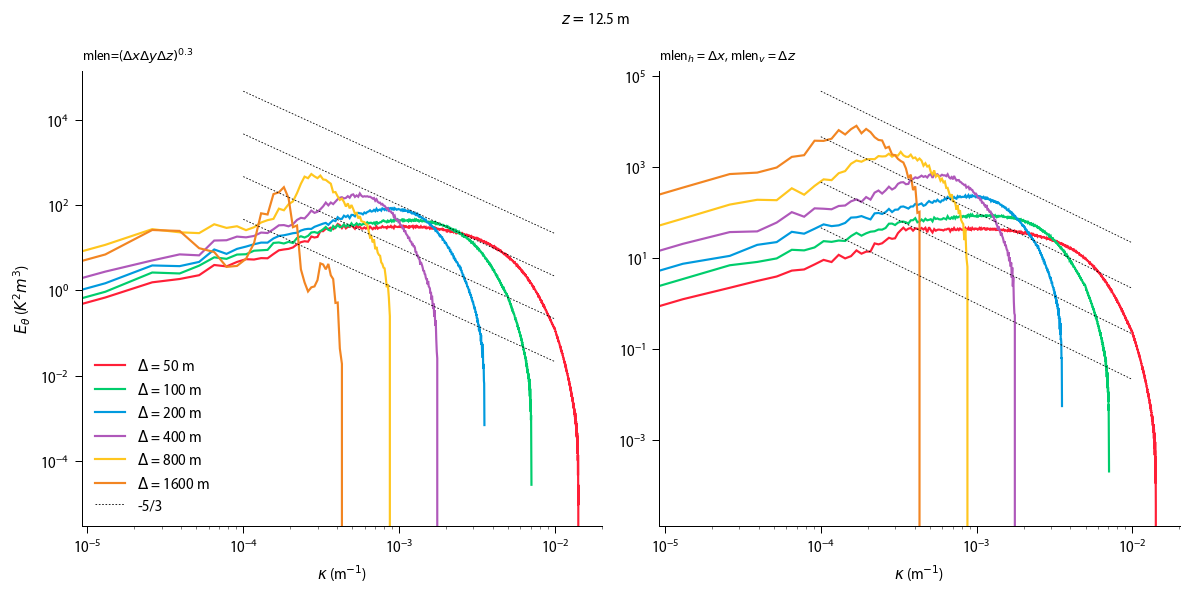

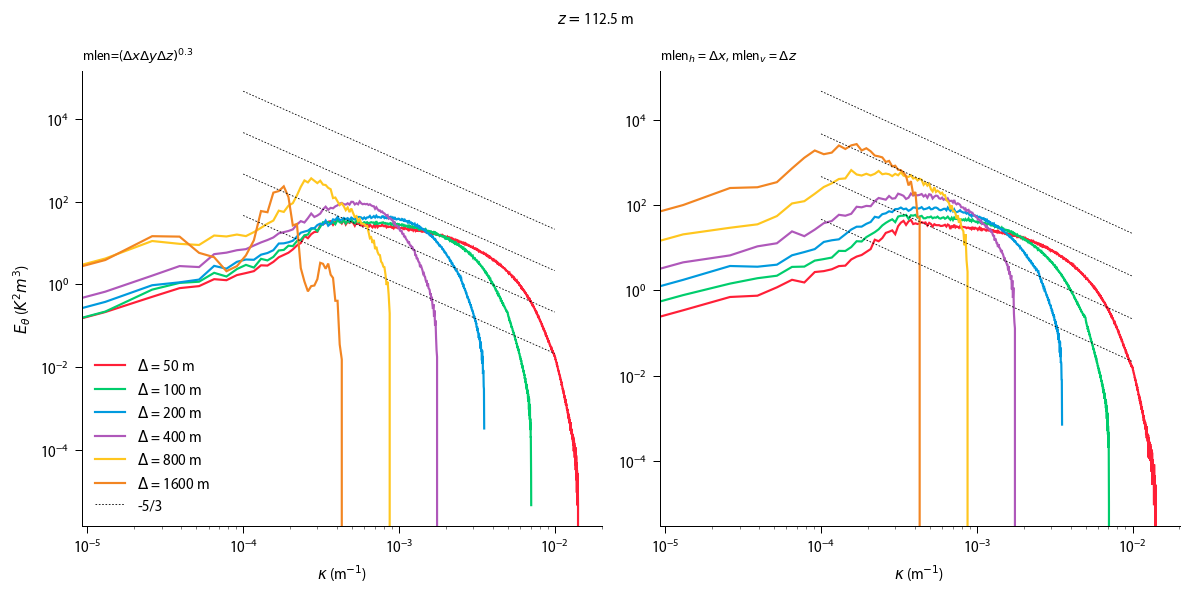

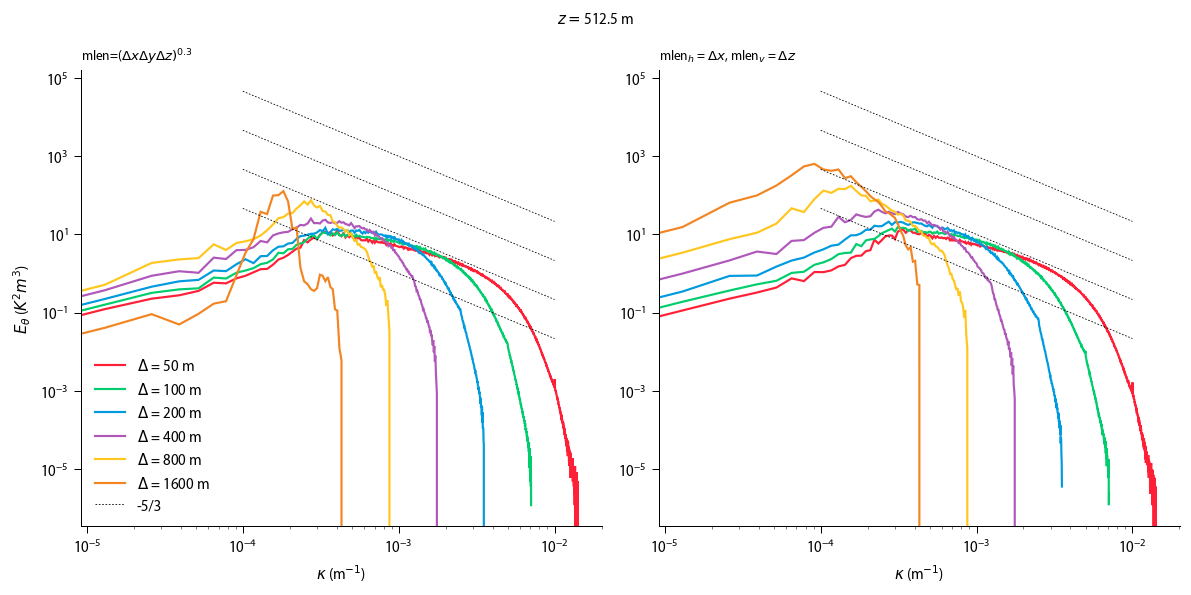

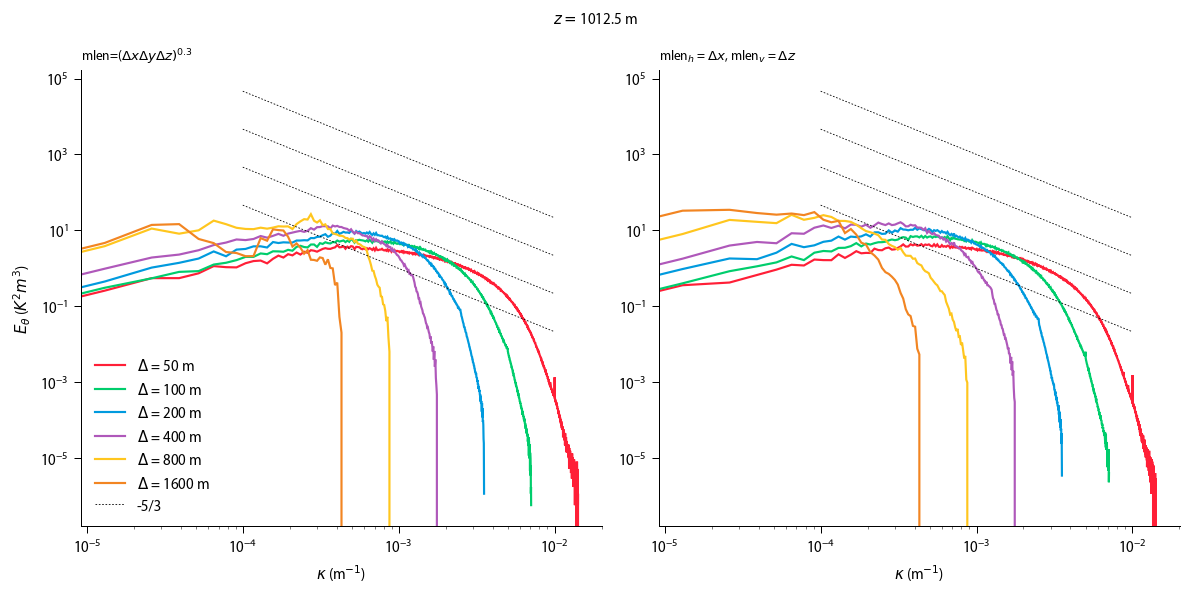

In [26]:
"""
TTTTTTTTTTTTTTTTTTTTTTTTTTT
"""
pl.close('all')

z = np.array([12.5, 112.5, 512.5,1012.5])

for k in range(z.size):

    pl.figure(figsize=(10,5), layout='tight')
    pl.suptitle(rf'$z=${z[k]} m')
    pl.subplot(121)
    pl.title(fr'mlen=($\Delta x \Delta y \Delta z)^{{{1/3:.1f}}}$', loc='left', size=8)
    for itot in itot_range[::-1]:
        s = s_th[f'{itot}x{itot}_{u}_iso_{k}']
        pl.loglog(s.k_phy, s.PSD, label=rf'$\Delta$ = {s.xsize/itot:.0f} m')
    plot_53()
    pl.legend()
    pl.xlabel(r'$\kappa$ (m$^{-1}$)')
    #pl.ylim(1e-7, 1e-1)
    pl.ylabel(r'$E_\theta$ ($K^2 m^3$)')

    pl.subplot(122)
    pl.title(fr'mlen$_h$ = $\Delta x$, mlen$_v$ = $\Delta z$', loc='left', size=8)
    for itot in itot_range[::-1]:
        s = s_th[f'{itot}x{itot}_{u}_aniso_{k}']
        pl.loglog(s.k_phy, s.PSD)
    plot_53()
    pl.xlabel(r'$\kappa$ (m$^{-1}$)')
    #pl.ylim(1e-7, 1e-1)

    pl.savefig(f'figs/drycbl_spectra_th_{k}.png')

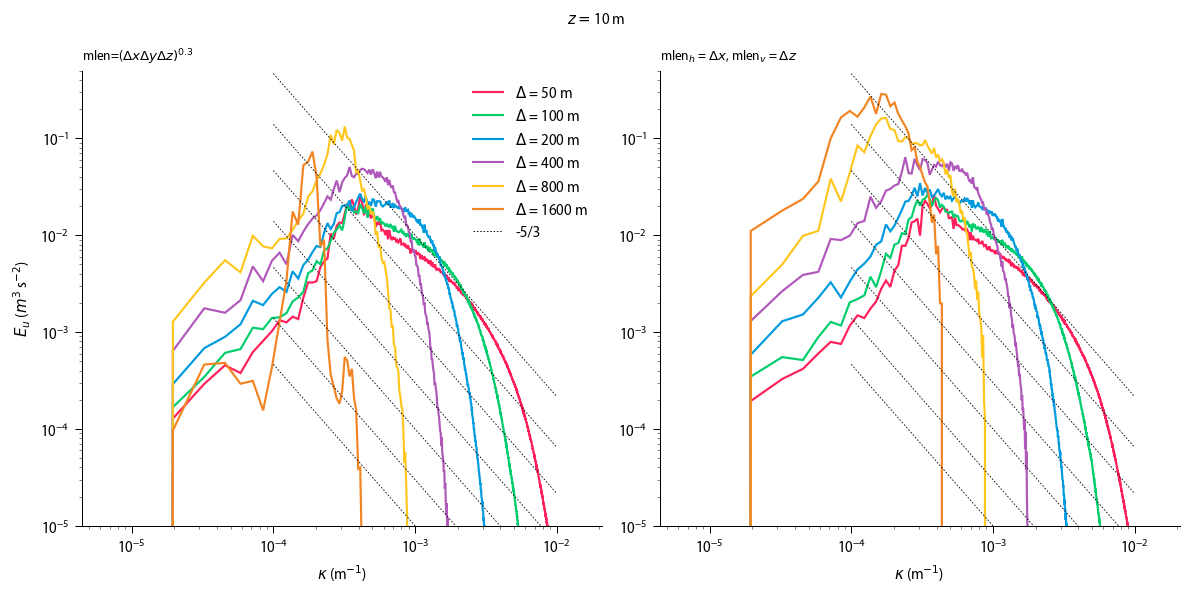

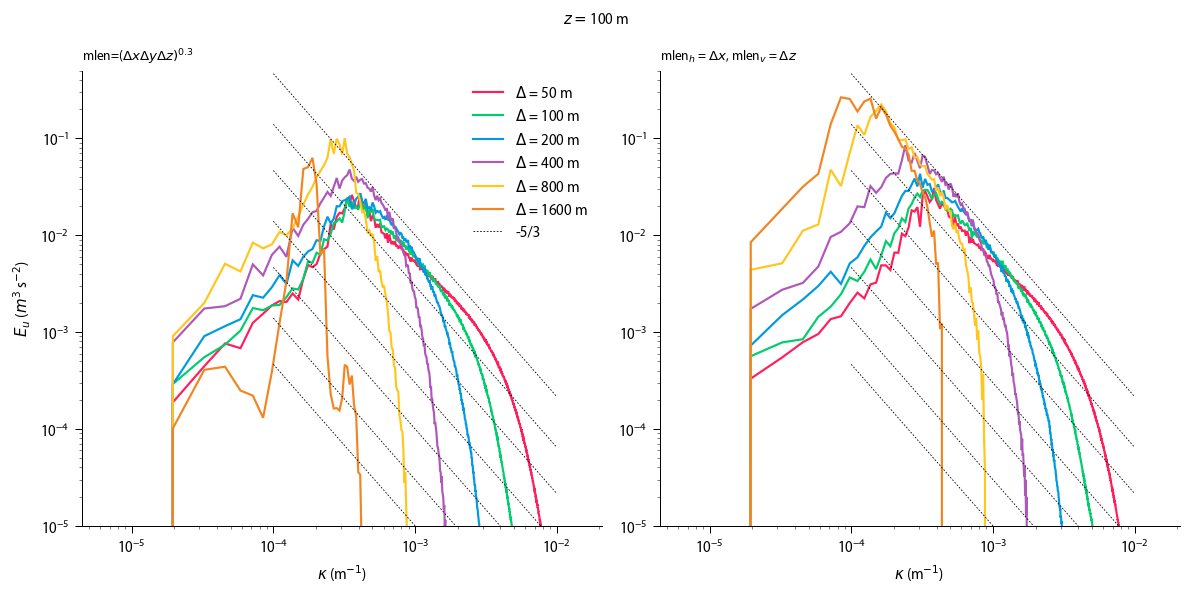

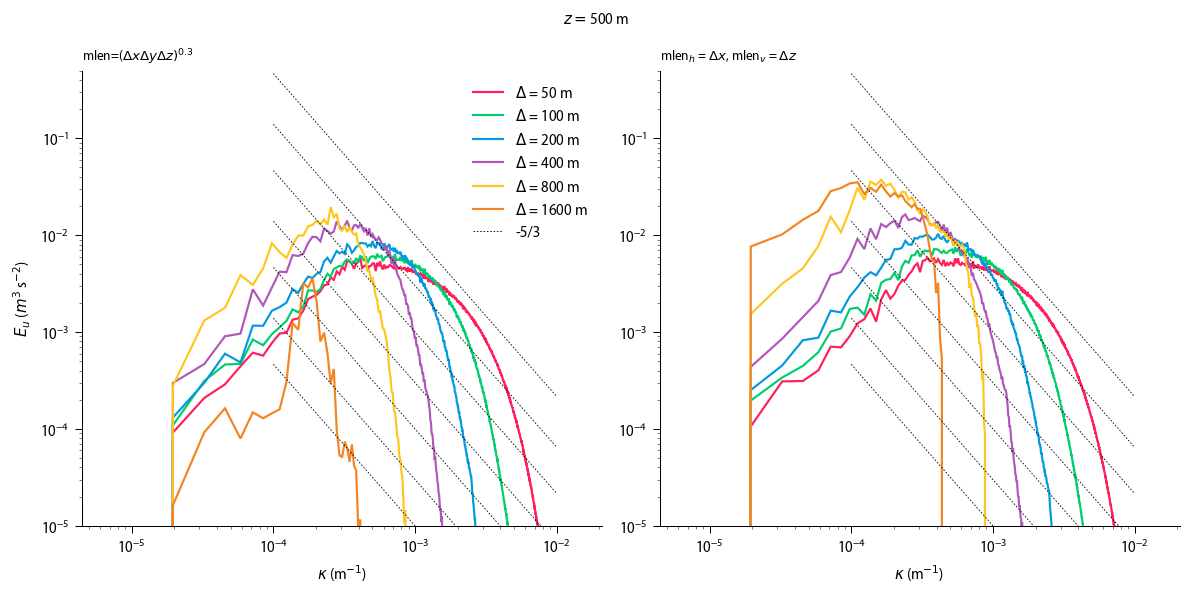

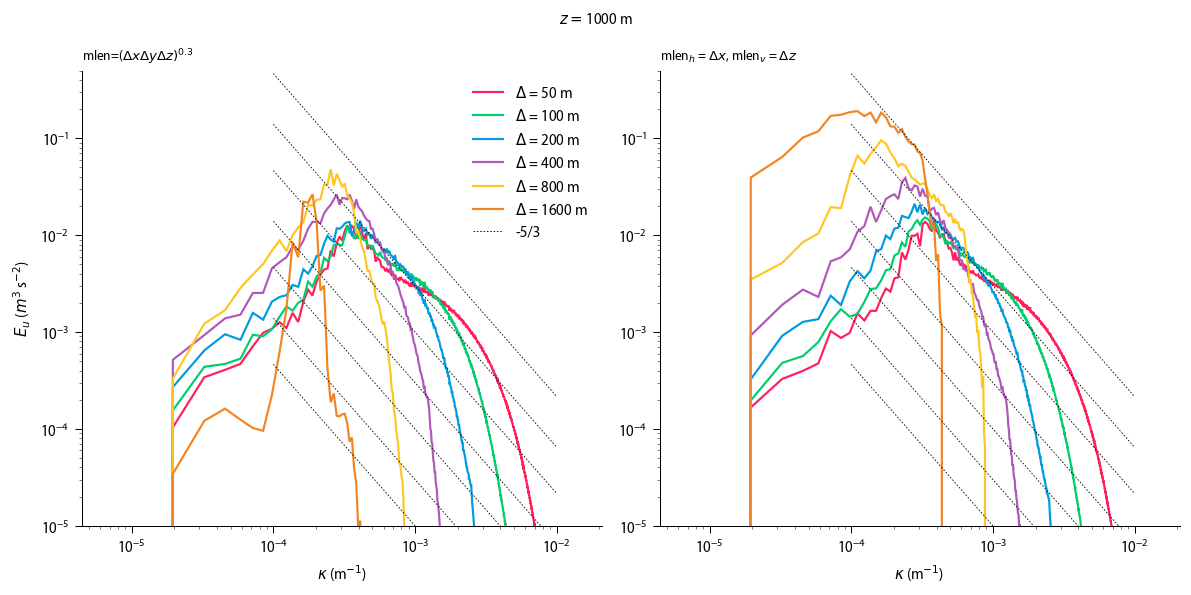

In [14]:
"""
UUUUUUUUUUUUUUUUUUUUUUUUUUUUUU
"""
pl.close('all')

z = np.array([10,100,500,1000])

for k in range(z.size):

    pl.figure(figsize=(10,5), layout='tight')
    pl.suptitle(rf'$z=${z[k]} m')
    pl.subplot(121)
    pl.title(fr'mlen=($\Delta x \Delta y \Delta z)^{{{1/3:.1f}}}$', loc='left', size=8)
    for itot in itot_range[::-1]:
        s = s_u[f'{itot}x{itot}_{u}_iso_{k}']
        pl.loglog(s.ks, s.spectra, label=rf'$\Delta$ = {s.xsize/itot:.0f} m')
    plot_53()
    pl.legend()
    pl.xlabel(r'$\kappa$ (m$^{-1}$)')
    pl.ylim(1e-5, 5e-1)
    pl.ylabel(r'$E_u$ ($m^3$ s$^{-2}$)')

    pl.subplot(122)
    pl.title(fr'mlen$_h$ = $\Delta x$, mlen$_v$ = $\Delta z$', loc='left', size=8)
    for itot in itot_range[::-1]:
        s = s_u[f'{itot}x{itot}_{u}_aniso_{k}']
        pl.loglog(s.ks, s.spectra)
    plot_53()
    pl.xlabel(r'$\kappa$ (m$^{-1}$)')
    pl.ylim(1e-5, 5e-1)

    pl.savefig(f'figs/drycbl_spectra_u_{k}.png')

In [ ]:
"""
WWWWWWWWWWWWWWWWWWWWWWWWWWWWw
"""

z = np.array([10,100,500,1000])

for k in range(1,z.size):

    pl.figure(figsize=(10,5), layout='tight')
    pl.suptitle(rf'$z=${z[k]} m')
    pl.subplot(121)
    pl.title(fr'mlen=($\Delta x \Delta y \Delta z)^{{{1/3:.1f}}}$', loc='left', size=8)
    for itot in itot_range:
        s = s_w[f'{itot}x{itot}_{u}_iso_{k}']
        pl.loglog(s.ks, s.spectra, label=rf'$\Delta$ = {s.xsize/itot:.0f} m')
    plot_53()
    pl.legend()
    pl.xlabel(r'$\kappa$ (m$^{-1}$)')
    pl.ylim(1e-7, 1e-1)
    pl.ylabel(r'$E_w(\kappa)$ ($m^3$ s$^{-2}$)')

    pl.subplot(122)
    pl.title(fr'mlen$_h$ = $\Delta x$, mlen$_v$ = $\Delta z$', loc='left', size=8)
    for itot in itot_range:
        s = s_w[f'{itot}x{itot}_{u}_aniso_{k}']
        pl.loglog(s.ks, s.spectra)
    plot_53()
    pl.xlabel(r'$\lambda$ (m)')
    pl.ylim(1e-7, 1e-1)